# CSC2042S 2025 Assignment 1: Unsupervised Learning
### Maryam Abrahams
### ABRMAR043
### 18th August 2025

## Part 1:  Data Preprocessing

Conducting exploratory analysis and visualising data using t-SNE dimensionality reduction and the scikit-learn toolbox. Part and parcel of this analysis is the proper documentation alongside it, including justifications, characteristics, and the impact of each preprocessing decision.

T-SNE (t-distributed stochastic neighbour embedding ) takes a high-dimensional dataset and reduces it to a low-dimensional graph, which retains a lot of the data. It does so largely through clustering and maintaining variance, similar to the process of Principal Component Analysis.

In [87]:
# imports, setup, and understanding our data

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import random
import numpy as np

df = pd.read_csv("WDICSV.csv")
display(df.head())

# To preprocess the data, we want to take this high-dimensional dataset and reduce it to a low-dimensional one

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,18.001597,18.558234,19.043572,19.586457,20.192064,20.828814,21.372164,22.100884,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.096003,7.406706,7.666648,8.020952,8.403358,8.718306,9.097176,9.473374,NaN,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.488233,38.779953,39.068462,39.445526,39.818645,40.276374,40.687817,41.211606,NaN,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,33.922276,38.859598,40.223744,43.035073,44.390861,46.282371,48.127211,48.801258,50.668330,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,16.527554,24.627753,25.432092,27.061929,29.154282,31.022083,32.809138,33.783960,35.375216,NaN


To perform t-SNE on our dataset, we must first reshape the data in such a way that t-SNE will be effective, removing missing features and very incomplete country years so that we don't have such a massive amount of missing data as well as reshaping the data to be better for clustering:

Row completeness per threshold:
   Threshold 50% -> 4338 rows kept (25.2%)
   Threshold 60% -> 2427 rows kept (14.1%)
   Threshold 70% -> 469 rows kept (2.7%)
   Threshold 80% -> 2 rows kept (0.0%)
Original shape of pivoted dataset: (17225, 1518)
Original # of country-year observations: 17225
Original # of features (x): 1515

Data shape after dropping completely empty columns: (469, 1458)


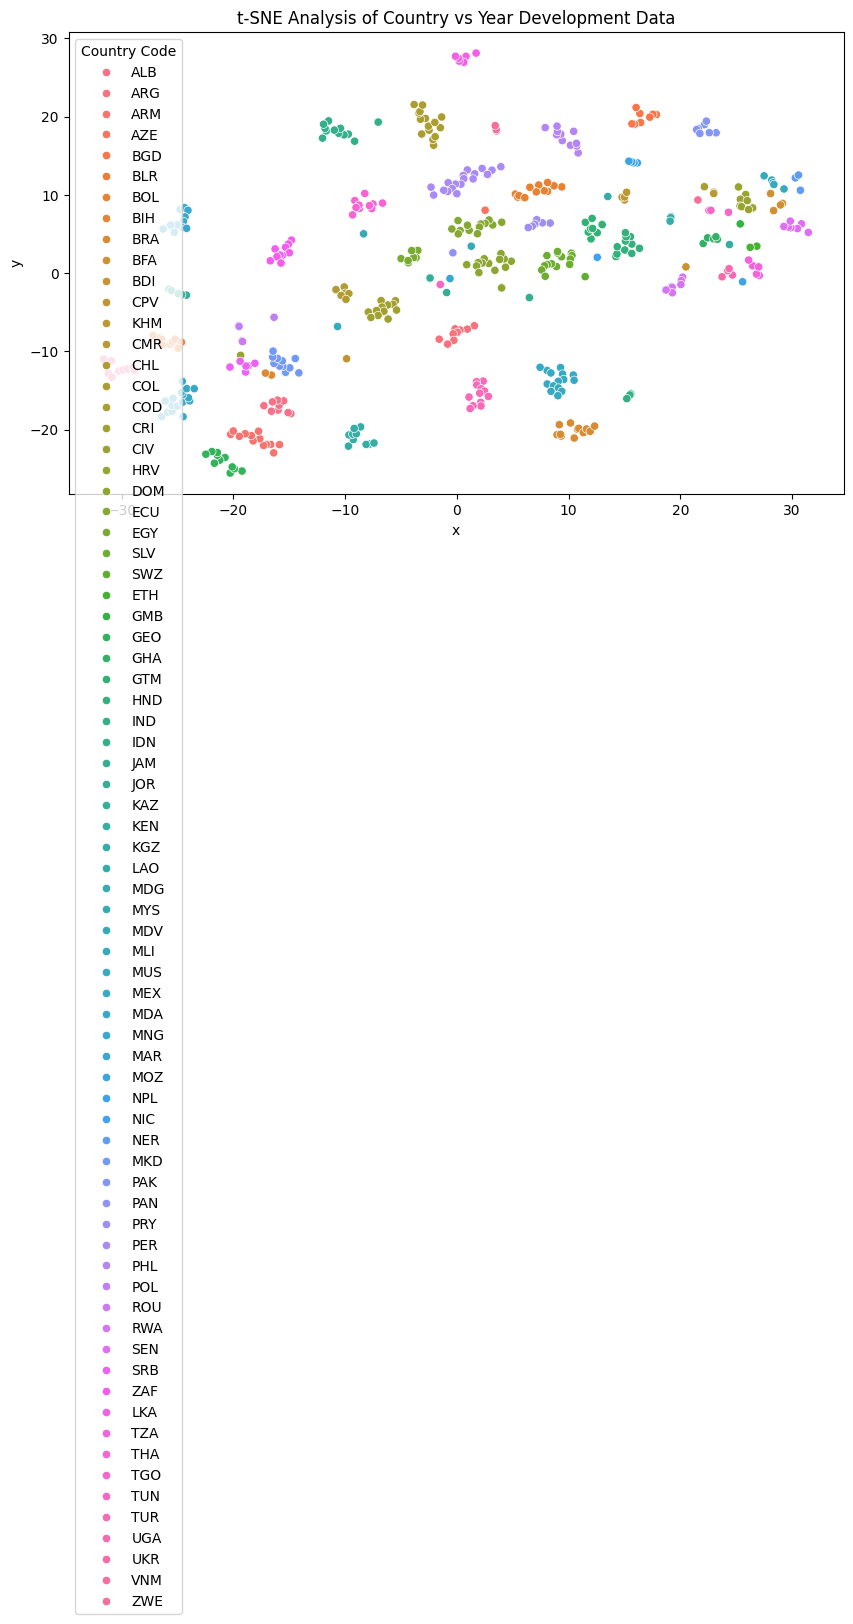

In [78]:
# Reshaping so that there are (Country-year) rows:
df_long = df.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
    var_name = 'Year', 
    value_name = 'Value'
)

df_wide = df_long.pivot_table(
    index = ['Country Name', 'Country Code', 'Year'],
    columns = 'Indicator Code', 
    values = 'Value'
).reset_index()

# Testing different thresholds: 
print("Row completeness per threshold:")
thresholds = [0.5, 0.6, 0.7, 0.8]
for t in thresholds:
    mask = df_wide.drop(['Country Name', 'Country Code', 'Year'], axis=1).notna().mean(axis=1) >= t
    remaining = len(df_wide[mask])
    print(f"   Threshold {t*100:.0f}% -> {remaining} rows kept ({(remaining/len(df_wide))*100:.1f}%)")
    
# Data Collection for Analysis & Justification:
og_shape = df_wide.shape
print("Original shape of pivoted dataset: " + str(og_shape))
print("Original # of country-year observations: " + str(og_shape[0]))
print("Original # of features (x): " + str(og_shape[1] - 3) + "\n")

# Cleaning the missing data:
numeric_pt = df_wide.drop(['Country Name', 'Country Code', 'Year'], axis=1).notna().mean(axis=1) >= 0.7
df_wide = df_wide[numeric_pt]

features = df_wide.drop(['Country Name', 'Country Code', 'Year'], axis=1)
features = features.fillna(features.mean())

# first I must drop entirely empty rows 
features = features.dropna(axis=1, how='all')
print("Data shape after dropping completely empty columns: " + str(features.shape))

# Conducting t-SNE dimensionality reduction on our dataframe:
# resources used: https://youtu.be/85XaciPBCkw

# Scaling features:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

m = TSNE(n_components=2, learning_rate = 50)
tsne_features = m.fit_transform(features_scaled)

df_wide['x'] = tsne_features[:,0]
df_wide['y'] = tsne_features[:,1]

# Ordering countries by value instead of numerically:
#country_order = df_wide.groupby('Indicator Code')['x'].mean().sort_values().index

plt.figure(figsize=(10,6))
sns.scatterplot(x='x', y ='y', hue='Country Code', data = df_wide)
plt.title("t-SNE Analysis of Country vs Year Development Data")
plt.show()

## Part 2: K-means clustering; Initialization

Selecting k initial centroids randomly from the dataset, where k is the number of clusters you want to find. We want to only use numpy data structures for our K-means clustering implementation.

In [41]:
# Using the K-means clustering tutorial memo as a guideline: 
# Setup: 

def initialise_centroids(X, k):
    # Choose k unique random indices
    indices = random.sample(range(len(X)), k)
    return [X[i] for i in indices]
    
def compute_cluster_mean(cluster_list):
    #For null values
    if len(cluster_list) == 0:
        return None 
    return np.mean(cluster_list, axis=0)

def compute_euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

def form_new_clusters(X, centroids):
    clusters = [[] for _ in centroids]
    for x in X:
        centroid_distances = [compute_euclidean_distance(x, c) for c in centroids]
        new_cluster = np.argmin(centroid_distances)
        clusters[new_cluster].append(x)
    return clusters

def compute_new_centroids(cluster_list):
    centroids = []
    for cluster_data in cluster_list:
        new_centroid = compute_cluster_mean(cluster_data)
        centroids.append(new_centroid)
    return centroids

def repeat_until_convergence(X, cluster_list, centroids):
    centroid_diff = 10000
    count = 0 #keeping track of the number of iterations
    while centroid_diff > 0:
        new_cluster_list = form_new_clusters(X, centroids)
        new_centroids = compute_new_centroids(new_cluster_list)
        centroid_diff = max([compute_euclidean_distance(centroids[i], new_centroids[i]) for i in range(len(centroids))])
        centroids = new_centroids
        cluster_list = new_cluster_list
        print(centroid_diff)
        count += 1
    return cluster_list, centroids, count

After this setup we now want to implement and compare multiple initialization strategies to understand the effects that differing initializaton will have on the end clustering result. We want to implement both random initialization, using multiple different random seeds and running his test multiple times, as well as K-means ++ initialization, selecting initial centres that are very far apart.

In [83]:
# Random Initialization:

X = features_scaled
k = 10 

# For different seeds:
random_results = []

for seed in [1, 2, 3, 4, 5]:
    np.random.seed(seed)
    random.seed(seed)
    print(f"\n--- Seed {seed} ---")
    centroids = initialise_centroids(X, k)
    cluster_list = form_new_clusters(X, centroids)
    final_clusters, final_centroids, iterations = repeat_until_convergence(X, cluster_list, centroids)

    #loss function
    loss = 0
    for j in range(len(final_clusters)):
        for point in final_clusters[j]:
            loss += compute_euclidean_distance(point, final_centroids[j]**2)
    loss = round(loss, 2)

    print()
    if iterations > 1 and iterations != 0: 
        print("It took " + str(iterations) + " iterations for the algorithm to converge with random initialization.")
        print(f"With final loss: {loss}")
    else: 
        print("It took " + str(iterations) + " iteration for the algorithm to converge with random initialization.")
        print(f"With final loss: {loss}")

    random_results.append({'seed': seed, 'iterations': iterations, 'loss': loss})


--- Seed 1 ---
37.81006404523605
10.942066060812326
4.983971652934839
2.3487933980861104
4.015966987718303
5.801499793084254
11.984153685149678
12.404353545700532
10.517982479963202
2.9160175699108533
0.0

It took 11 iterations for the algorithm to converge with random initialization.
With final loss: 22241.87

--- Seed 2 ---
30.607542637827624
8.409341447005758
19.07204274917192
5.350987472209934
6.1181924912844625
5.066200012057751
8.138117611138478
15.938047022441197
2.9160175699108533
0.662515267528377
0.0

It took 11 iterations for the algorithm to converge with random initialization.
With final loss: 20799.41

--- Seed 3 ---
40.885978428167
14.580505104571632
5.0131947276669315
4.88721709904035
8.449806436006831
1.504916497308088
1.5244531900748464
1.7002496437602053
2.2211198283492677
1.8737640438339602
2.4812010376390297
0.9155721143396652
1.0492062247223861
1.4248042376345331
0.5215308572172803
0.0

It took 16 iterations for the algorithm to converge with random initializatio

In [84]:
# Initialization via K-means++

def k_means_plus_plus(X,k):
    n_samples = X.shape[0]
    centroids = []
    c_one = np.random.randint(0, n_samples) 
    centroids.append(X[c_one])

    for i in range(1,k):  
        distances = np.array([min(np.linalg.norm(x-c)**2 for c in centroids) for x in X])
        probs = distances/distances.sum()
        c_new = np.random.choice(n_samples, p = probs) 
        centroids.append(X[c_new])
        
    return centroids

# Running our K-means++
kpp_results = []

for seed in [1, 2, 3, 4, 5]:
    np.random.seed(seed)
    random.seed(seed)
    print(f"\n--- Seed {seed} ---")
    centroids = k_means_plus_plus(X, k)
    cluster_list = form_new_clusters(X, centroids)
    final_clusters, final_centroids, iterations = repeat_until_convergence(X, cluster_list, centroids)
    
    #loss function
    loss = 0
    for j in range(len(final_clusters)):
        for point in final_clusters[j]:
            loss += compute_euclidean_distance(point, final_centroids[j]**2)
    loss = round(loss, 2)
                 
    print()
    if iterations > 1: 
        print("It took " + str(iterations) + " iterations for the algorithm to converge with k-means++.")
        print(f"With final loss: {loss}")
    else: 
        print("It took " + str(iterations) + " iteration for the algorithm to converge with random k_means++.")
        print(f"With final loss: {loss}")

    kpp_results.append({'seed': seed, 'iterations': iterations, 'loss': loss})


--- Seed 1 ---
48.00497711422638
14.132377423333818
8.855155406144885
7.475020223252444
0.8265648484777801
0.0

It took 6 iterations for the algorithm to converge with k-means++.
With final loss: 23836.06

--- Seed 2 ---
31.919246287830163
10.514029635415616
12.25914826680471
7.039327275543369
4.8217566636194285
3.0077886156692304
3.833978008706215
0.5198517111499814
0.0

It took 9 iterations for the algorithm to converge with k-means++.
With final loss: 21950.36

--- Seed 3 ---
35.52585004859378
20.503837516868494
18.482263271923973
37.01691661581763
8.472799375258356
6.372777931784498
19.10061504017041
3.3818456212903847
0.46441584949490594
0.0

It took 10 iterations for the algorithm to converge with k-means++.
With final loss: 24783.14

--- Seed 4 ---
34.433641304872395
8.898838275964001
8.416524640825516
3.656772337011412
1.9126978289610885
0.0

It took 6 iterations for the algorithm to converge with k-means++.
With final loss: 20258.49

--- Seed 5 ---
32.32290618879702
9.1993803

### Cluster Analysis: 
Visualizing the cluster centroids for each cluster in both the random and k-means++ initialization cases. From the similar spread of the centroids across different tests, we can see that there is a stability of cluster assignments across runs.

SUMMARY COMPARISON
Random Initialization:
  Avg. Iterations: 11.8, Avg. Loss: 20863.12 (±711.47)
K-means++ Initialization:
  Avg. Iterations: 8.8, Avg. Loss: 22163.84 (±1900.19)


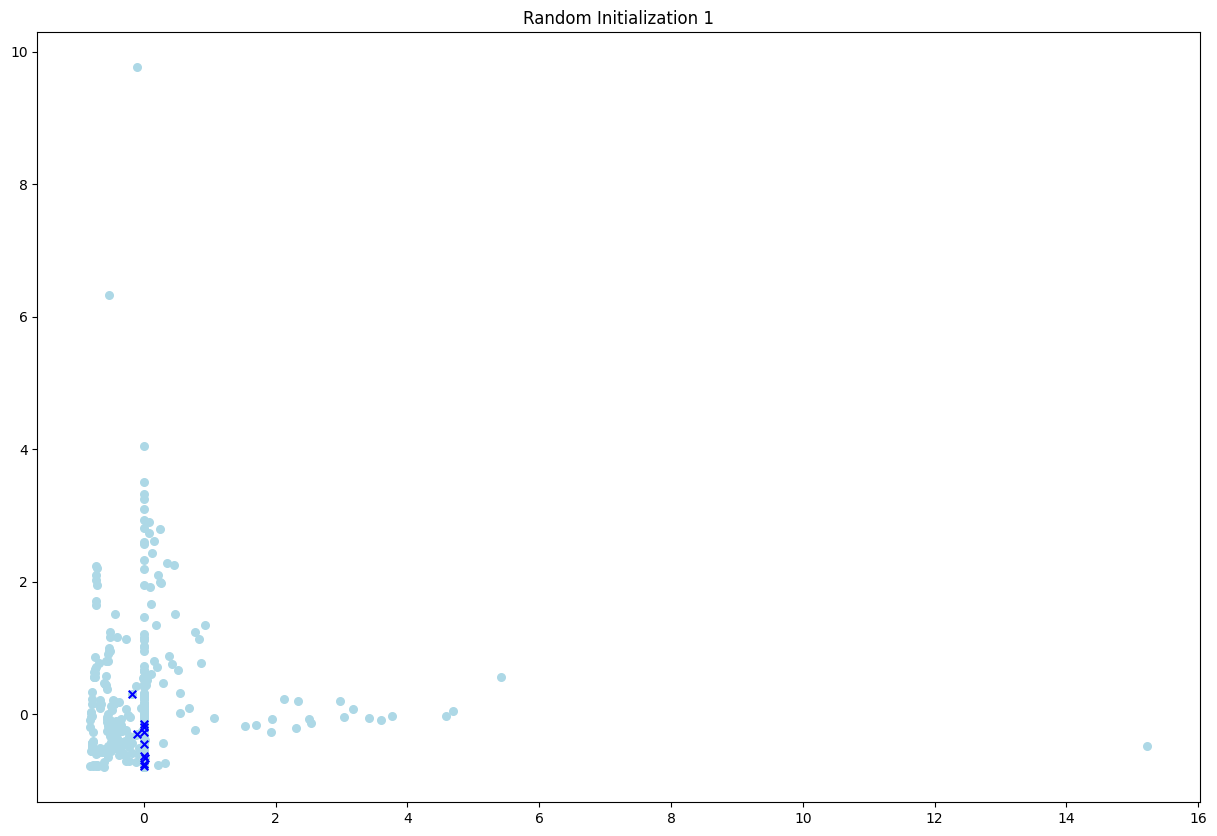

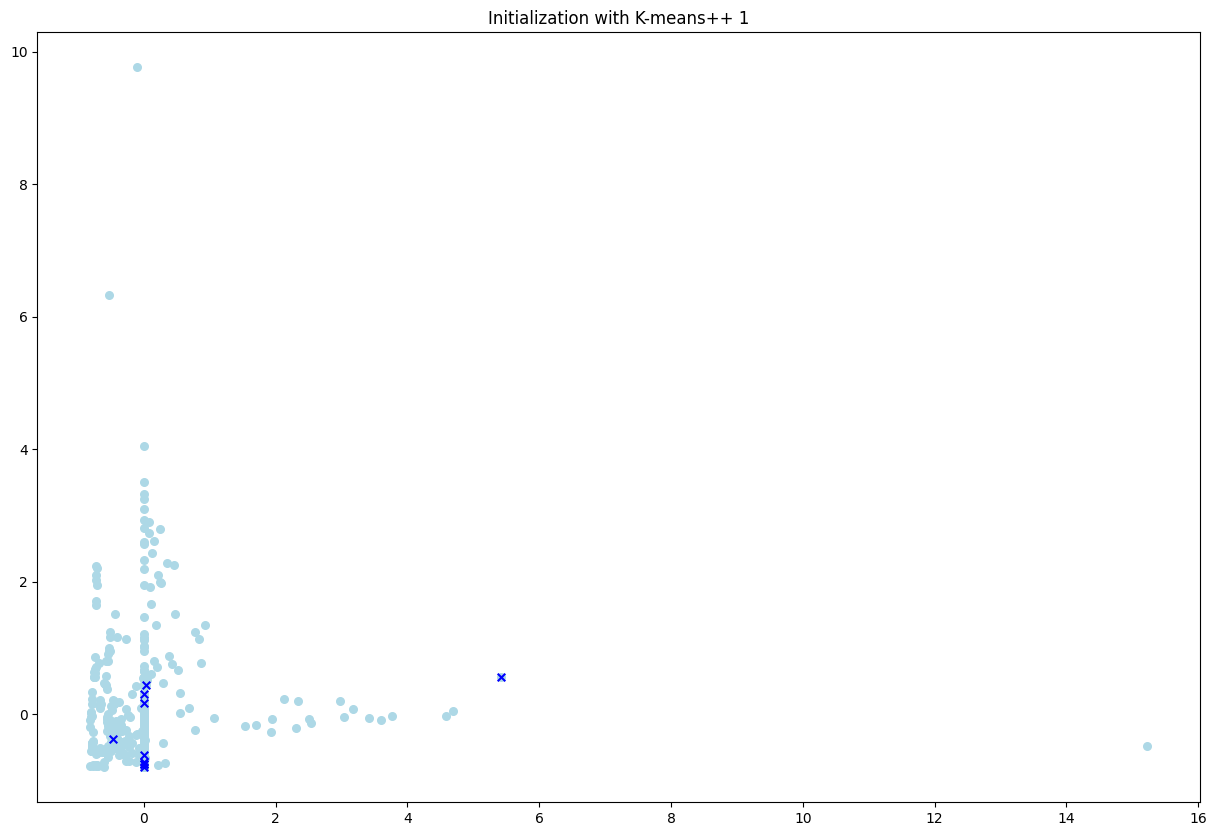

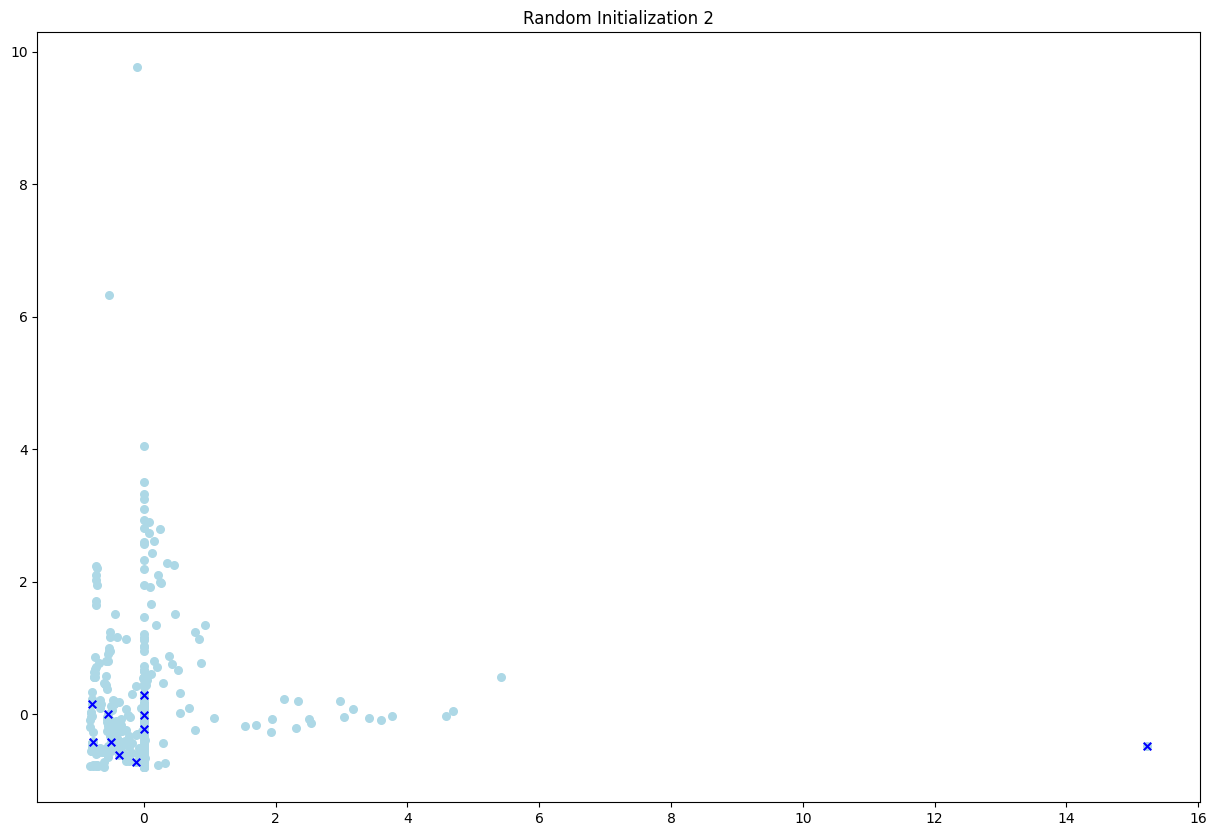

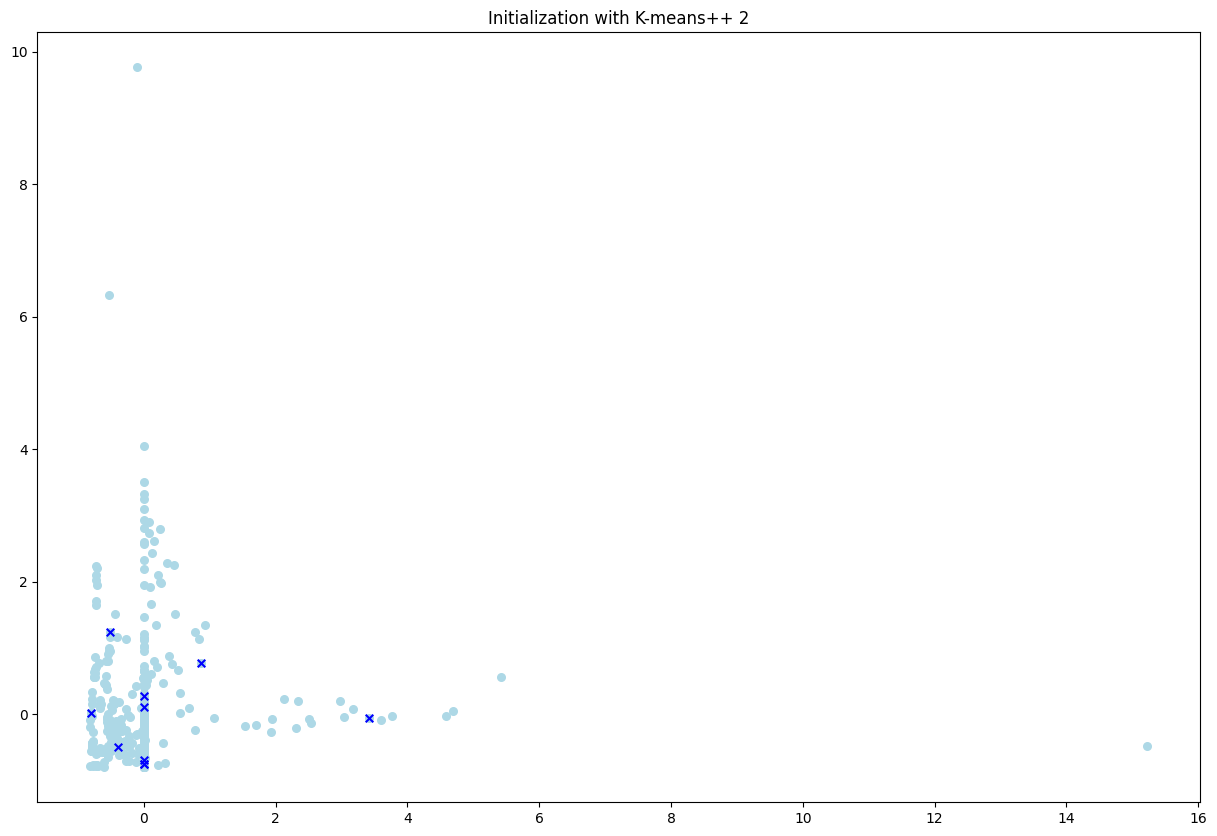

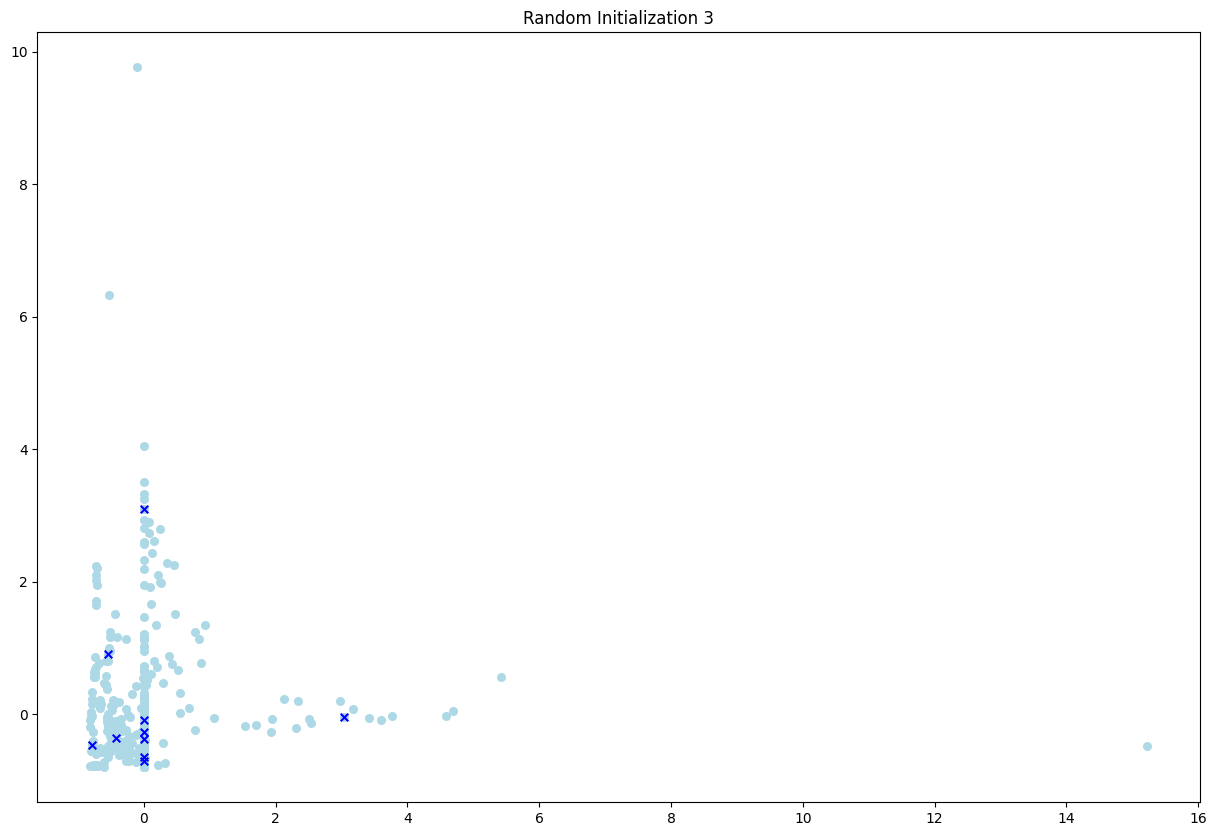

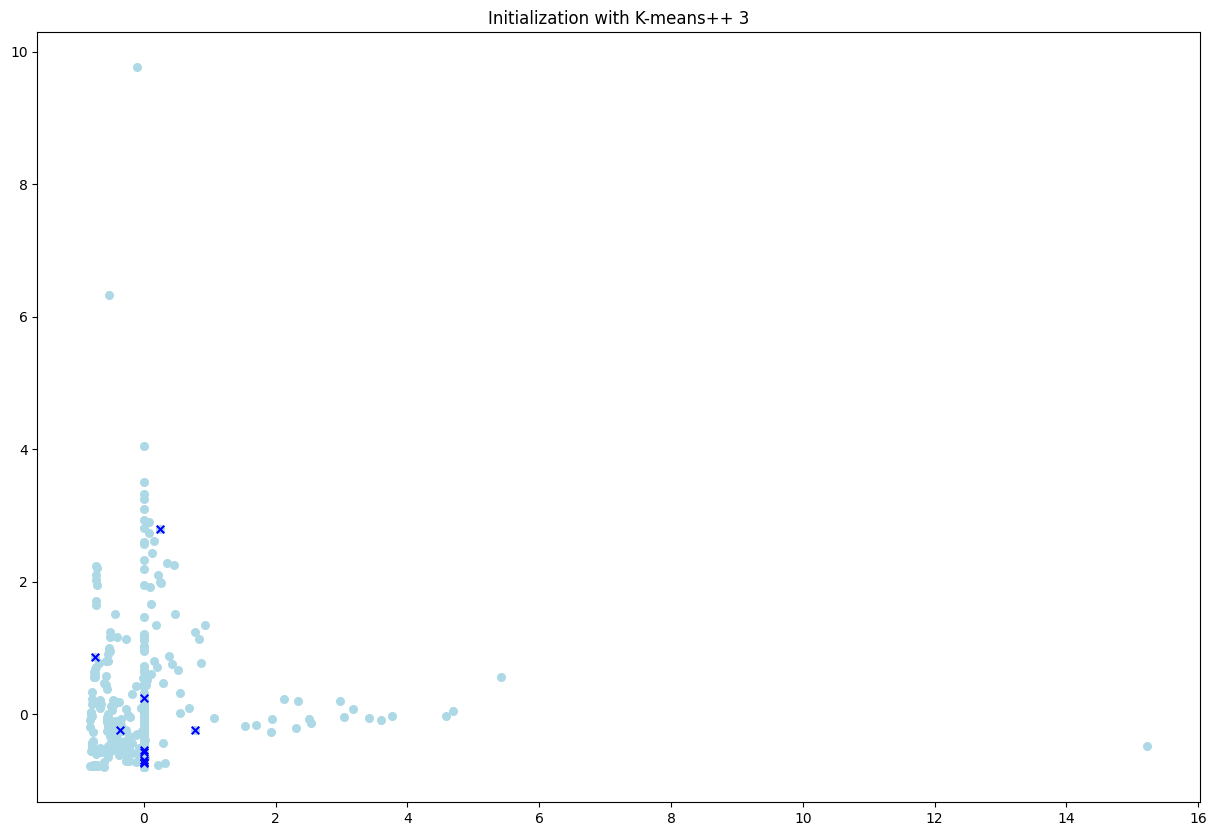

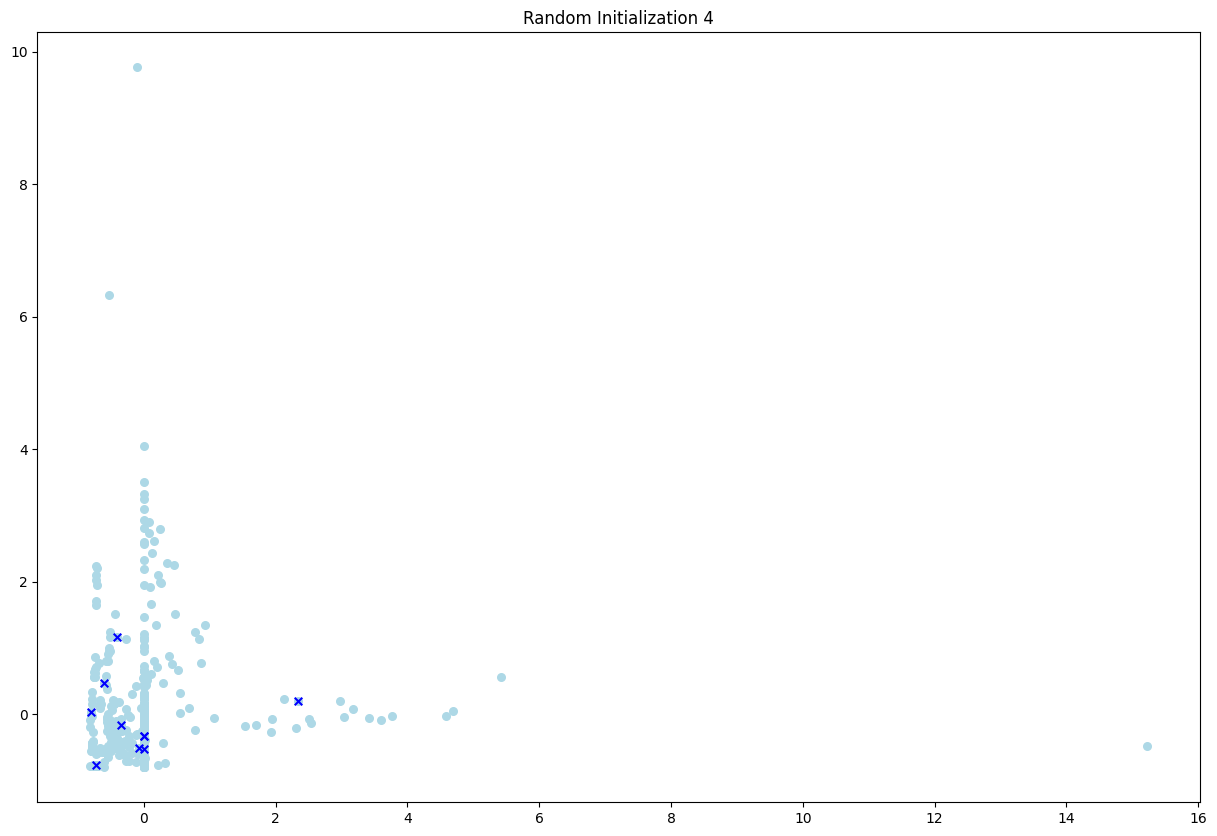

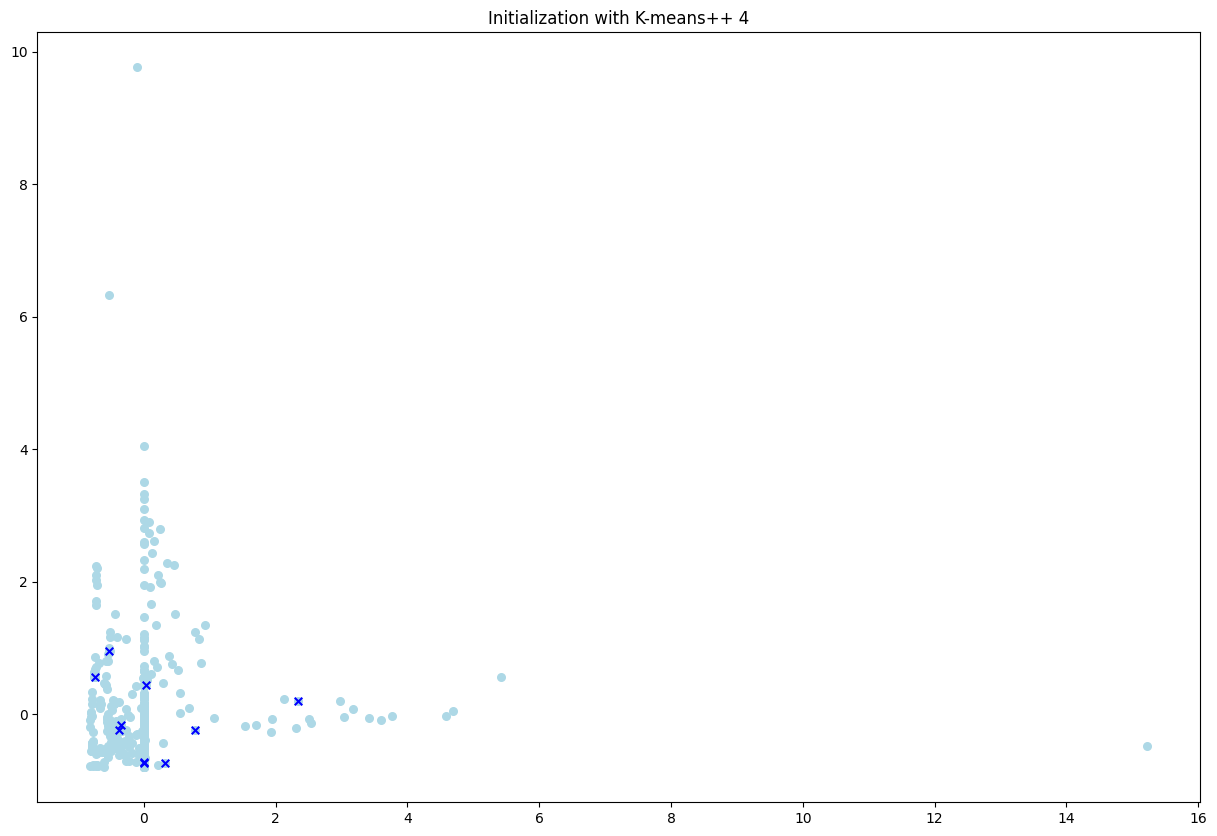

In [92]:
# Visualizing the final centroids & Summary
print("SUMMARY COMPARISON")
print("="*50)

avg_random_iter = np.mean([r['iterations'] for r in random_results])
avg_random_loss = np.mean([r['loss'] for r in random_results])
std_random_loss = np.std([r['loss'] for r in random_results])

avg_kpp_iter = np.mean([r['iterations'] for r in kpp_results])
avg_kpp_loss = np.mean([r['loss'] for r in kpp_results])
std_kpp_loss = np.std([r['loss'] for r in kpp_results])

print(f"Random Initialization:")
print(f"  Avg. Iterations: {avg_random_iter:.1f}, Avg. Loss: {avg_random_loss:.2f} (±{std_random_loss:.2f})")
print(f"K-means++ Initialization:")
print(f"  Avg. Iterations: {avg_kpp_iter:.1f}, Avg. Loss: {avg_kpp_loss:.2f} (±{std_kpp_loss:.2f})")

def plot_initial(X, centroids, title):
    centroids = np.array(centroids)
    plt.figure(figsize=(15,10))
    plt.scatter(X[:, 0], X[:,1], s=30, c="lightblue", label="Data")
    plt.scatter(centroids[:, 0], centroids[:, 1], c="blue", s=30, marker="x", label="Centroids")
    plt.title(title)
    plt.show()

seeds = [69, 420, 777, 1234]
for i, seed in enumerate(seeds, 1):
    print("="*120)
    np.random.seed(seed)
    random.seed(seed)
    c_random = initialise_centroids(X, k)
    c_kmeans = k_means_plus_plus(X, k) 
    plot_initial(X, c_random, f"Random Initialization {i}")
    plot_initial(X, c_kmeans, f"Initialization with K-means++ {i}")


## Part 3: Convergence Criteria

Implementing and evaluating multiple different convergence criteria, including: the maximum iterations, the centroid change threshold, and the inertia change threshold.

Importantly, we want to analyze how each of the above criteria affects the trade-off between computational cost and the solution's quality.

In [73]:
# k-means irrespective of stopping criteria

def kmeans(X, k, c_initial, max_it, c_change_min, inertia_change_min, stop = "max_it"): 
    centroids = c_initial.copy()
    inertia_past = []
    shifts = []
    count = 0
    
    for it in range(max_it): 
        cluster_list = form_new_clusters(X, centroids) 
        c_new = compute_new_centroids(cluster_list)

        #Handling empty clusters: 
        for i, cluster in enumerate(cluster_list):
            if len(cluster) == 0:
                c_new[i] = centroids[i]
            centroids = c_new
        
        shift = max([compute_euclidean_distance(centroids[i], c_new[i]) for i in range(len(centroids))])
        shifts.append(shift) 

        inertia = sum([sum([compute_euclidean_distance(x, c_new[i])**2 for x in cluster_list[i]]) for i in range(len(centroids))])
        inertia_past.append(inertia) 

        centroids = c_new
        count +=1

        # Stop conditions initial
        if stop == 'centroid' and shift < c_change_min:
            break
        elif stop == 'inertia' and it > 0 and abs(inertia_past[-2] - inertia_past[-1]) < inertia_change_min:
            break
        elif stop == 'max_it' and it == max_it - 1:
            break
            
    return cluster_list, centroids, count, inertia_past, shifts

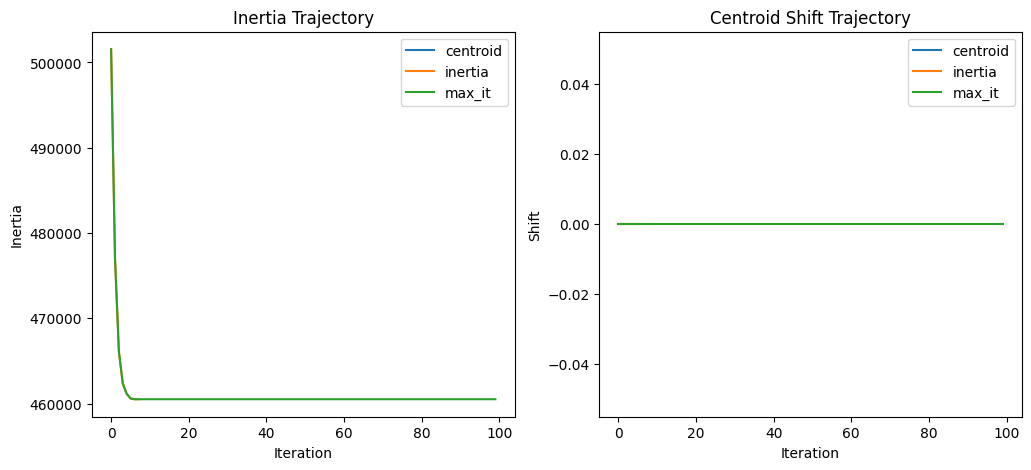

In [74]:
# Maximum Iterations, Centroid Change, and Inertia Change Checks: 

c_initial = X[np.random.choice(len(X), k, replace=False)]
results = {}
for mode in ["centroid", "inertia", "max_it"]: 
    results[mode] = kmeans(X, k, c_initial, max_it = 100, c_change_min = 0.001, inertia_change_min = 0.01, stop = mode)

# Plotting comparisons:

fig, axs = plt.subplots(1, 2, figsize=(12,5))

# Inertia
for mode, (_, _, _, inertia, _) in results.items():
    axs[0].plot(inertia, label=mode)
axs[0].set_title("Inertia Trajectory")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Inertia")
axs[0].legend()

# Centroid shift
for mode, (_, _, _, _, shifts) in results.items():
    axs[1].plot(shifts, label=mode)
axs[1].set_title("Centroid Shift Trajectory")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Shift")
axs[1].legend()

plt.show()

## Part 3: Determining the Optimal K

For K-means clustering, the optimal number of clusters is a fundamental challenge. Instinctively, we'd want to pick k such that the loss function is minimized; however, we don't want to fall victim to overfitting. To combat this, we'll use a hybrid approach of both manual and automated inspeection of the loss function graph.

## Part 5: Dimensionality reduction with PCS

We want to apply PCA dimensionality reduction to our preprocessed data so that we can visualize our cluster in both a 2D and 3D PCA space so that, alongside our K-means clustering and t-SNE tests, we can better interpret the spread of the data and identify which original features most strongly contribute to each component.

## Part 6: Cluster Interpretation


## Part 7.1: Outlier Analysis & Regression


## Part 7.2: Alternative clustering algorithm (Guassign Mixture Model)
